/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy Before GA (Logistic Regression, using all features): 0.7951
Accuracy Before GA (KNN, using all features): 0.7317
Selected Features for Logistic Regression after GA: ['age', 'sex', 'cp', 'trestbps', 'fbs', 'restecg', 'exang']
Selected Features for KNN after GA: ['age', 'sex', 'cp', 'trestbps', 'fbs', 'restecg', 'exang']
Accuracy After GA (Logistic Regression, using selected features): 0.8293
Accuracy After GA (KNN, using selected features): 0.8146


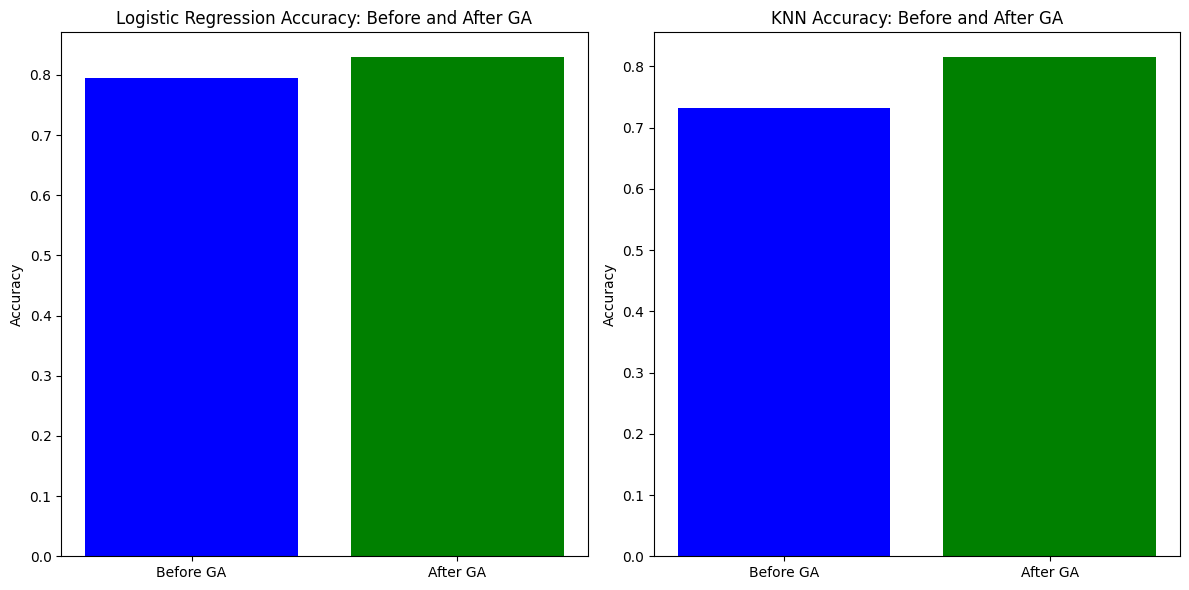

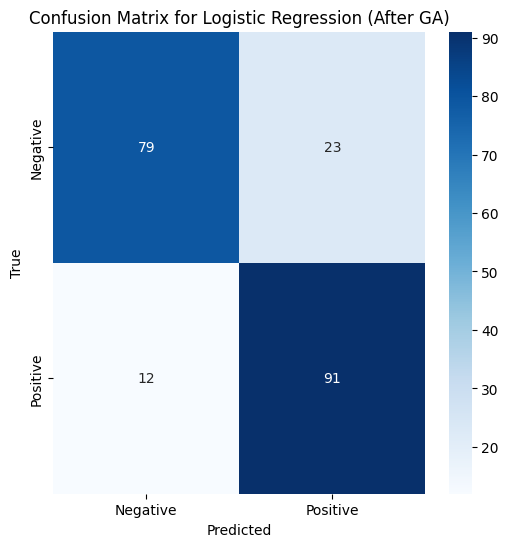

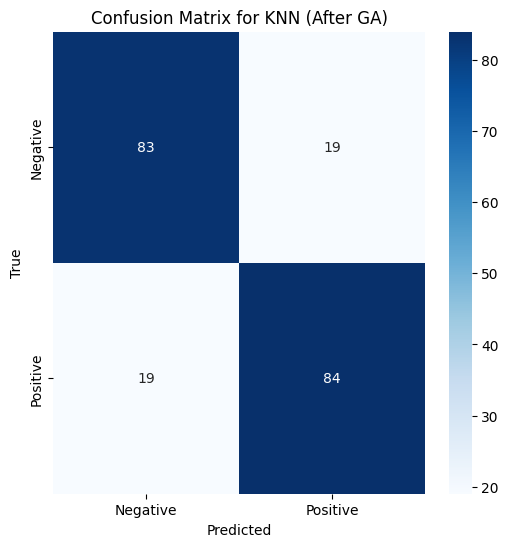

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

# Load dataset
data = pd.read_csv("/content/Cardio_vascular.xls")
X = data.iloc[:, :-1].values  # Features
y = data.iloc[:, -1].values   # Target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Logistic Regression model on all features (Baseline)
logreg_model = LogisticRegression(max_iter=1000)
logreg_model.fit(X_train, y_train)
y_pred_logreg = logreg_model.predict(X_test)
baseline_accuracy_logreg = accuracy_score(y_test, y_pred_logreg)

# Train a KNN model on all features (Baseline)
knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)
baseline_accuracy_knn = accuracy_score(y_test, y_pred_knn)

print(f"Accuracy Before GA (Logistic Regression, using all features): {baseline_accuracy_logreg:.4f}")
print(f"Accuracy Before GA (KNN, using all features): {baseline_accuracy_knn:.4f}")

# GA Implementation for feature selection
population_size = 20
num_generations = 30
mutation_rate = 0.1
crossover_rate = 0.8
num_features = X_train.shape[1]

# Initialize population (binary chromosomes)
def initialize_population(size, num_features):
    return np.random.randint(0, 2, (size, num_features))

# Fitness function
def fitness(chromosome, model, X_train, X_test, y_train, y_test):
    selected_features = [i for i in range(len(chromosome)) if chromosome[i] == 1]
    if not selected_features:
        return 0
    X_train_selected = X_train[:, selected_features]
    X_test_selected = X_test[:, selected_features]

    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)

    return accuracy_score(y_test, y_pred)

# Selection
def select_parents(population, fitness_scores):
    parents = []
    for _ in range(len(population)):
        i, j = np.random.choice(len(population), 2, replace=False)
        parents.append(population[i] if fitness_scores[i] > fitness_scores[j] else population[j])
    return np.array(parents)

# Crossover
def crossover(parent1, parent2):
    if np.random.rand() < crossover_rate:
        point = np.random.randint(1, len(parent1))
        child1 = np.concatenate((parent1[:point], parent2[point:]))
        child2 = np.concatenate((parent2[:point], parent1[point:]))
        return child1, child2
    return parent1, parent2

# Mutation
def mutate(chromosome):
    for i in range(len(chromosome)):
        if np.random.rand() < mutation_rate:
            chromosome[i] = 1 - chromosome[i]
    return chromosome

# GA Main Loop
population = initialize_population(population_size, num_features)
best_chromosome = None
best_fitness = -np.inf

for generation in range(num_generations):
    fitness_scores_logreg = np.array([fitness(chromosome, logreg_model, X_train, X_test, y_train, y_test) for chromosome in population])
    fitness_scores_knn = np.array([fitness(chromosome, knn_model, X_train, X_test, y_train, y_test) for chromosome in population])

    max_fitness_logreg = fitness_scores_logreg.max()
    max_fitness_knn = fitness_scores_knn.max()

    if max_fitness_logreg > best_fitness:
        best_fitness = max_fitness_logreg
        best_chromosome = population[fitness_scores_logreg.argmax()]

    # Select parents
    parents = select_parents(population, fitness_scores_logreg)  # Selection based on LogReg accuracy

    # Perform crossover and mutation
    next_population = []
    for i in range(0, len(parents), 2):
        parent1, parent2 = parents[i], parents[min(i + 1, len(parents) - 1)]
        child1, child2 = crossover(parent1, parent2)
        next_population.append(mutate(child1))
        next_population.append(mutate(child2))

    population = np.array(next_population[:population_size])

# Assuming you have the feature names in the original dataset
feature_names = data.columns[:-1]  # Excluding the target column

# Best Chromosome and its Accuracy after GA (for Logistic Regression)
selected_features_logreg = [i for i in range(len(best_chromosome)) if best_chromosome[i] == 1]
selected_feature_names_logreg = [feature_names[i] for i in selected_features_logreg]

X_train_selected_logreg = X_train[:, selected_features_logreg]
X_test_selected_logreg = X_test[:, selected_features_logreg]

logreg_model.fit(X_train_selected_logreg, y_train)
y_pred_logreg_ga = logreg_model.predict(X_test_selected_logreg)
ga_accuracy_logreg = accuracy_score(y_test, y_pred_logreg_ga)

# Best Chromosome and its Accuracy after GA (for KNN)
selected_features_knn = [i for i in range(len(best_chromosome)) if best_chromosome[i] == 1]
selected_feature_names_knn = [feature_names[i] for i in selected_features_knn]

X_train_selected_knn = X_train[:, selected_features_knn]
X_test_selected_knn = X_test[:, selected_features_knn]

knn_model.fit(X_train_selected_knn, y_train)
y_pred_knn_ga = knn_model.predict(X_test_selected_knn)
ga_accuracy_knn = accuracy_score(y_test, y_pred_knn_ga)

# Display the selected features
print(f"Selected Features for Logistic Regression after GA: {selected_feature_names_logreg}")
print(f"Selected Features for KNN after GA: {selected_feature_names_knn}")

print(f"Accuracy After GA (Logistic Regression, using selected features): {ga_accuracy_logreg:.4f}")
print(f"Accuracy After GA (KNN, using selected features): {ga_accuracy_knn:.4f}")

# Plotting the comparison
accuracies_logreg = [baseline_accuracy_logreg, ga_accuracy_logreg]
accuracies_knn = [baseline_accuracy_knn, ga_accuracy_knn]
labels = ['Before GA', 'After GA']

# Subplot to compare both models
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Logistic Regression Comparison
axs[0].bar(labels, accuracies_logreg, color=['blue', 'green'])
axs[0].set_title("Logistic Regression Accuracy: Before and After GA")
axs[0].set_ylabel("Accuracy")

# KNN Comparison
axs[1].bar(labels, accuracies_knn, color=['blue', 'green'])
axs[1].set_title("KNN Accuracy: Before and After GA")
axs[1].set_ylabel("Accuracy")

plt.tight_layout()
plt.show()

# Confusion Matrix for Logistic Regression
cm_logreg = confusion_matrix(y_test, y_pred_logreg_ga)
plt.figure(figsize=(6, 6))
sns.heatmap(cm_logreg, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title("Confusion Matrix for Logistic Regression (After GA)")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Confusion Matrix for KNN
cm_knn = confusion_matrix(y_test, y_pred_knn_ga)
plt.figure(figsize=(6, 6))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title("Confusion Matrix for KNN (After GA)")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# New Section